In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import svm
from sklearn.metrics import log_loss, roc_auc_score, roc_curve

In [2]:
%matplotlib inline

### Preliminary plotting functions

In [3]:
def get_class_limits(df, x1_col, x2_col, target_column, extend_factor = 1.5):
    """
    Find the limits of the positive class, extended by a factor
    
    df: data frame holding the data
    x1_col, x2_col: the columns holding the input features 
    target_column: the column holding the target variable
    extend_factor: factor by which to extend the limits
    
    return: x1_min, x1_max, x2_min, x2_max
    """
    x_matr = df[df[target_column] == 1][[x1_col, x2_col]].as_matrix()
    x1_min, x1_max = np.min(x_matr[:,0]),  np.max(x_matr[:,0])
    x2_min, x2_max =  np.min(x_matr[:,1]),  np.max(x_matr[:,1])
    mid1, ext1 = (x1_min + x1_max) / 2., (-x1_min + x1_max) / 2.
    mid2, ext2 = (x2_min + x2_max) / 2., (-x2_min + x2_max) / 2.
    return mid1 - extend_factor * ext1, mid1 + extend_factor * ext1,  mid2 - extend_factor * ext2, mid2 + extend_factor * ext2,


def create_grid(x1_min, x1_max, x2_min, x2_max, num_points=101):
    """
    Create a grid with num_points points in each dimension. 
    
    x1_min, x1_max, x2_min, x2_max: float, the grid limits
    num_points: int
    """
    dx1 = (x1_max - x1_min) / (num_points - 1)
    dx2 = (x2_max - x2_min) / (num_points - 1)
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, dx1),
                         np.arange(x2_min, x2_max, dx2))
    return xx, yy


def plot_decision_boundary(ax, clf, feat_mesh, mesh_shape, cm = plt.cm.Blues):
    """
    Plot the decision boundary. For that, we will assign a color to each
    point in the mesh [x_min, m_max]x[y_min, y_max].
    
    ax: an axis object
    clf: trained classifier object
    feat_mesh: numpy array, each column has the values of input features on a flattened mesh
    cm: colormap to use in the plot
    """
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(feat_mesh)
    else:
        Z = clf.predict_proba(feat_mesh)[:, 1]

    # Put the result into a color plot
    xx, yy = feat_mesh[:, 0].reshape(mesh_shape), feat_mesh[:, 1].reshape(mesh_shape)
    Z = Z.reshape(mesh_shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    return ax

    
def plot_points(ax, X, y, cm_bright = ListedColormap(['#FF0000', '#0000FF']), alpha=0.3):
    """
    Plot the training and test points.
    """
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=alpha)
    # testing points
    #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
    #           alpha=0.6)
    return ax


def form_figure(ax, xx, yy, name, score):
    """
    Create a generic figure template.
    """
    ##ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    return ax


def balance_data(df, target_column, balabce_ratio = 1.):
    """
    Pick a random sample from a data frame, such that all examples 
    of the minority class are kept, and the ratio between classes is 
    balance_ratio.
    
    df: pandas DataFrame
    target_column: the label of the target column
    balance_ratio: the balance of the two classes in the resulting data frame
    """
    class_fraction = df[target_column].mean()
    df_r = df.copy()
    df_r['random'] = np.random.uniform(low=0., high=1., size=df.shape[0])
    return df_r[((df_r['random'] <= class_fraction) & (df_r[target_column] == 0)) | (df_r[target_column] == 1)]


def assign_class_quadr(x1, x2, n1, n2, alpha, offset=0.2):
    """
    Generate the class labels for the data, according to a quadratic boundary. 
    Positive class is x2 >= alpha * x1^2
    
    x1, x2: numpy array
    n1, n2: numpy arrays with noise in each coordinate (generates a random shift for each point's class)
    alpha: float, the coefficient for the quadratic function
    """
    unity = np.ones(np.shape(x1))
    return np.logical_and(np.greater_equal(x2+n2, alpha * np.power(x1+n1, 6)), 
                          np.less_equal(x2+n2, offset*unity + np.power(x1+n1, 2))).astype('float')


def assign_class_lin(x1, x2, n1, n2, kappa):
    """
    Generate the class labels for the data, according to a linear boundary. 
    Positive class is x1 + x2 <= kappa
    
    x1, x2: numpy arrays with coordinates
    n1, n2: numpy arrays with noise in each coordinate (generates a random shift for each point's class)
    kappa: float, the intercept of the boundary with the axes
    """
    return np.less_equal(x1 + n1 + x2 + n2, kappa).astype('float')

### Quadratic boundary

The rule for class I is: 

$$C_{I} = \left\{ (x_1,x_2):\, x_2 \geq \alpha \ x_1^2 \right\}$$

Then, for data bounded in the area $|x_1|, |x_2| \leq 1$, the area occupied by class I is:

$$2\,\int_{0}^{1}\sqrt{y/\alpha}\,dy = \frac{4}{3\sqrt{\alpha}}$$

and the relative fraction of class I is $$3\,\sqrt{\alpha}$$

#### Generate data and assign classes:

In [4]:
alph = 2
ns  = 0.01
#I = np.ones(50000)
X1 = np.random.uniform(low=-1., high=1., size=10000)
X2 = np.random.uniform(low=-1., high=1., size=10000)
n1 = np.random.normal(loc=0.0, scale=ns, size=10000)
n2 = np.random.normal(loc=0.0, scale=ns, size=10000)
Y = np.transpose(assign_class_quadr(X1, X2, n1, n2, alph))

## I now X1^2 wil be important, add it as a feature
X = np.vstack((X1, X2, np.power(X1, 2), np.power(X2, 2))).T

df = pd.DataFrame(data=np.vstack((X.T, Y)).T, columns=['X1', 'X2', 'X1sq', 'X2sq', 'Y'])
df_b = balance_data(df, target_column='Y', balabce_ratio=1.)
X_b = df_b[['X1', 'X2', 'X1sq', 'X2sq']].as_matrix()
Y_b = np.ravel(df_b[['Y']].as_matrix())

In [5]:
#clf = LogisticRegressionCV(Cs=30, class_weight='auto', cv=6, dual=False,
#                           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
#                           multi_class='ovr', n_jobs=3, penalty='l2', refit=True,
#                           scoring=None, solver='lbfgs', tol=1e-06, verbose=0)

#clf_b = LogisticRegressionCV(Cs=30, class_weight='auto', cv=6, dual=False, 
#                             fit_intercept=True, intercept_scaling=1.0, max_iter=1000, 
#                             multi_class='ovr', n_jobs=3, penalty='l2', refit=True, 
#                             scoring=None, solver='lbfgs', tol=1e-06, verbose=0)
clf = LogisticRegression(C = 30.)
clf_b = LogisticRegression(C = 30.)
#clf = svm.SVC(class_weight='auto', kernel='rbf', probability=True)
#clf_b = svm.SVC(class_weight='auto', kernel='rbf', probability=True)

clf.fit(X, Y)
clf_b.fit(X_b, Y_b)

LogisticRegression(C=30.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [6]:
# Test data
#I = np.ones(50000)
X1t = np.random.uniform(low=-1., high=1., size=10000)
X2t = np.random.uniform(low=-1., high=1., size=10000)
n1t = np.random.normal(loc=0.0, scale=ns, size=10000)
n2t = np.random.normal(loc=0.0, scale=ns, size=10000)

Yt = np.transpose(assign_class_quadr(X1t, X2t, n1t, n2t, alph))

Xt = np.vstack((X1t, X2t, np.power(X1, 2), np.power(X2, 2))).T

dft = pd.DataFrame(data=np.vstack((Xt.T, Yt)).T, columns=['X1', 'X2', 'X1sq', 'X2sq', 'Y'])
dft_b = balance_data(dft, target_column='Y', balabce_ratio=1.)
X_b = dft_b[['X1', 'X2', 'X1sq', 'X2sq']].as_matrix()
Y_b = np.ravel(dft_b[['Y']].as_matrix())
print "Fraction of class 1: %4.3f" % Yt.mean()

Fraction of class 1: 0.141


In [7]:
print "Score on balanced data: %4.3f" %clf.score(Xt, Yt)
print "Score on unbalanced data: %4.3f" %clf_b.score(Xt, Yt)

y_pred = clf.predict_proba(Xt)
yb_pred = clf_b.predict_proba(Xt)
print "Log loss on balanced data: %4.3f" %log_loss(Yt, y_pred)
print "Log loss on unbalanced data: %4.3f" %log_loss(Yt, yb_pred)

print "ROC-AUC on balanced data: %4.3f" % roc_auc_score(Yt, y_pred[:,1])
print "ROC-AUC on unbalanced data: %4.3f" % roc_auc_score(Yt, yb_pred[:,1])

Score on balanced data: 0.724
Score on unbalanced data: 0.696
Log loss on balanced data: 1.072
Log loss on unbalanced data: 1.453
ROC-AUC on balanced data: 0.638
ROC-AUC on unbalanced data: 0.647


In [8]:
x1_min, x1_max, x2_min, x2_max = get_class_limits(df, 'X1', 'X2', 'Y', extend_factor = 1.5)
x1b_min, x1b_max, x2b_min, x2b_max = get_class_limits(df_b, 'X1', 'X2', 'Y', extend_factor = 1.5)

xx, yy =  create_grid(x1_min, x1_max, x2_min, x2_max, num_points=101)

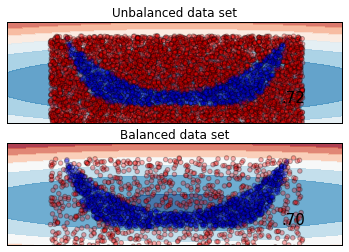

In [9]:
ax1 = plt.subplot(2,1,1)
ax1 = form_figure(ax1, xx, yy, name='Unbalanced data set', score=clf.score(Xt, Yt))
ax1 = plot_decision_boundary(ax1, clf, 
                             np.c_[xx.ravel(), 
                                   yy.ravel(), 
                                   np.power(xx, 2).ravel(), 
                                   np.power(yy, 2).ravel()],
                             xx.shape, cm=plt.cm.RdBu)
ax1 = plot_points(ax1, Xt, Yt)
ax2 = plt.subplot(2,1,2)
ax2 = form_figure(ax2, xx, yy, name='Balanced data set', score=clf_b.score(Xt, Yt))
ax2 = plot_decision_boundary(ax2, clf_b, 
                             np.c_[xx.ravel(), 
                                   yy.ravel(), 
                                   np.power(xx, 2).ravel(), 
                                   np.power(yy, 2).ravel()],
                             yy.shape, cm=plt.cm.RdBu)
ax2 = plot_points(ax2, X_b, Y_b)

plt.show()

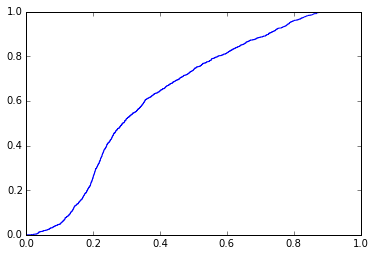

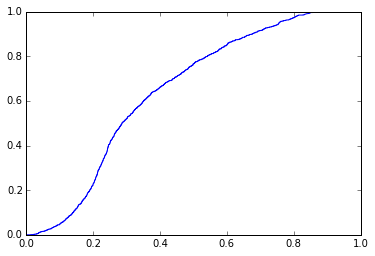

In [10]:
fpr, tpr, thrs = roc_curve(Yt, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()

fpr, tpr, thrs = roc_curve(Yt, yb_pred[:,1])
plt.plot(fpr, tpr)
plt.show()

### Quadratic boundary, SVM

In [11]:
alph = 2
ns = 0.01
#I = np.ones(50000)
X1 = np.random.uniform(low=-1., high=1., size=10000)
X2 = np.random.uniform(low=-1., high=1., size=10000)
n1 = np.random.normal(loc=0.0, scale=ns, size=10000)
n2 = np.random.normal(loc=0.0, scale=ns, size=10000)

Y = np.transpose(assign_class_quadr(X1, X2, n1, n2, alph, offset=0.1))

## I now X1^2 wil be important, add it as a feature
X = np.vstack((X1, X2)).T

df = pd.DataFrame(data=np.vstack((X.T, Y)).T, columns=['X1', 'X2', 'Y'])
df_b = balance_data(df, target_column='Y', balabce_ratio=1.)
X_b = df_b[['X1', 'X2']].as_matrix()
Y_b = np.ravel(df_b[['Y']].as_matrix())

In [12]:
clf = svm.SVC(class_weight='auto', kernel='rbf', probability=True)
clf_b = svm.SVC(class_weight='auto', kernel='rbf', probability=True)

clf.fit(X, Y)
clf_b.fit(X_b, Y_b)

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [13]:
# Test data
#I = np.ones(50000)
X1t = np.random.uniform(low=-1., high=1., size=10000)
X2t = np.random.uniform(low=-1., high=1., size=10000)
n1t = np.random.normal(loc=0.0, scale=ns, size=10000)
n2t = np.random.normal(loc=0.0, scale=ns, size=10000)

Yt = np.transpose(assign_class_quadr(X1t, X2t, n1t, n2t, alph, offset=0.1))

Xt = np.vstack((X1t, X2t)).T

dft = pd.DataFrame(data=np.vstack((Xt.T, Yt)).T, columns=['X1', 'X2', 'Y'])
dft_b = balance_data(dft, target_column='Y', balabce_ratio=1.)
X_b = dft_b[['X1', 'X2']].as_matrix()
Y_b = np.ravel(dft_b[['Y']].as_matrix())
print "Fraction of class 1: %4.3f" % Yt.mean()

Fraction of class 1: 0.096


In [14]:
print "Score on balanced data: %4.3f" %clf.score(Xt, Yt)
print "Score on unbalanced data: %4.3f" %clf_b.score(Xt, Yt)

y_pred = clf.predict_proba(Xt)
yb_pred = clf_b.predict_proba(Xt)
print "Log loss on balanced data: %4.3f" %log_loss(Yt, y_pred)
print "Log loss on unbalanced data: %4.3f" %log_loss(Yt, yb_pred)

print "ROC-AUC on balanced data: %4.3f" % roc_auc_score(Yt, y_pred[:,1])
print "ROC-AUC on unbalanced data: %4.3f" % roc_auc_score(Yt, yb_pred[:,1])

Score on balanced data: 0.762
Score on unbalanced data: 0.737
Log loss on balanced data: 0.168
Log loss on unbalanced data: 0.343
ROC-AUC on balanced data: 0.943
ROC-AUC on unbalanced data: 0.936


In [15]:
x1_min, x1_max, x2_min, x2_max = get_class_limits(df, 'X1', 'X2', 'Y', extend_factor = 1.5)
x1b_min, x1b_max, x2b_min, x2b_max = get_class_limits(df_b, 'X1', 'X2', 'Y', extend_factor = 1.5)

xx, yy =  create_grid(x1_min, x1_max, x2_min, x2_max, num_points=101)

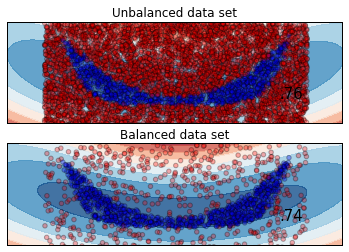

In [16]:
ax1 = plt.subplot(2,1,1)
ax1 = form_figure(ax1, xx, yy, name='Unbalanced data set', score=clf.score(Xt, Yt))
ax1 = plot_decision_boundary(ax1, clf, 
                             np.c_[xx.ravel(), 
                                   yy.ravel()],
                             xx.shape, cm=plt.cm.RdBu)
ax1 = plot_points(ax1, Xt, Yt)
ax2 = plt.subplot(2,1,2)
ax2 = form_figure(ax2, xx, yy, name='Balanced data set', score=clf_b.score(Xt, Yt))
ax2 = plot_decision_boundary(ax2, clf_b, 
                             np.c_[xx.ravel(), 
                                   yy.ravel()],
                             yy.shape, cm=plt.cm.RdBu)
ax2 = plot_points(ax2, X_b, Y_b)

plt.show()

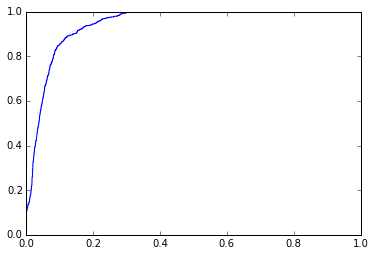

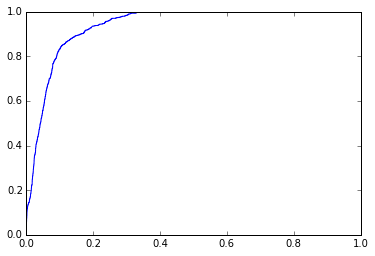

In [17]:
fpr, tpr, thrs = roc_curve(Yt, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()

fpr, tpr, thrs = roc_curve(Yt, yb_pred[:,1])
plt.plot(fpr, tpr)
plt.show()